In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import os
import logging
import itertools
import random
import warnings
warnings.filterwarnings("ignore")
import glob
import gym
from gym import spaces
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Import Data

In [3]:
folder_path = '../csv/solar_energy_prod'
all_csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = [pd.read_csv(file) for file in all_csv_files]
df = pd.concat(df_list, ignore_index=True)

df['datetime']=pd.to_datetime(df['date']).drop(columns=['date'])
df['date'] = pd.to_datetime(df['datetime'].dt.date)

print(df.shape)
df.head()

(258423, 9)


,name,id,address,date,kWh,public_url,installationDate,uid,datetime
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00,2017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00,2017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00,2017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00,2017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017-09-11,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00,2017-09-11 12:00:00


# Data Preparation

In [4]:
print(df.dtypes)
df['kWh'].describe()

name                        object
id                           int64
address                     object
date                datetime64[ns]
kWh                        float64
public_url                  object
installationDate            object
uid                         object
datetime            datetime64[ns]
dtype: object


count    258423.000000
mean         38.059762
std          71.598031
min           0.000000
25%           1.370000
50%           8.034000
75%          35.876000
max         514.462000
Name: kWh, dtype: float64

In [5]:
# df['datetime']=pd.to_datetime(df['date'])
df.sort_values(by=['name','datetime'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
plant = 'Whitehorn Multi-Service Centre'
df0 = df[df.name==plant]
df0.count()['date']

np.int64(27716)

In [7]:
# plt.style.use('fivethirtyeight')
# plt.plot(df0.date, df0['kWh'], label=f'{plant} Solar Energy Production')
# plt.tight_layout()
# plt.xlabel("DateTime")
# plt.ylabel("kWh Solar Produced")
# plt.xticks(rotation=30)
# plt.legend()
# plt.grid(True)

# plt.show()

In [8]:
min_max_dates = df['date'].agg(['min', 'max'])

print("Min and Max Dates:")
print(min_max_dates)

Min and Max Dates:
min   2015-09-01
max   2023-03-16
Name: date, dtype: datetime64[ns]


In [9]:
# filter for two years
df1 = df0[df0.date>='2021/01/01']
min_max_dates = df1['date'].agg(['min', 'max'])

print("Min and Max Dates after date filtering:")
print(min_max_dates)

Min and Max Dates after date filtering:
min   2021-01-01
max   2023-03-16
Name: date, dtype: datetime64[ns]


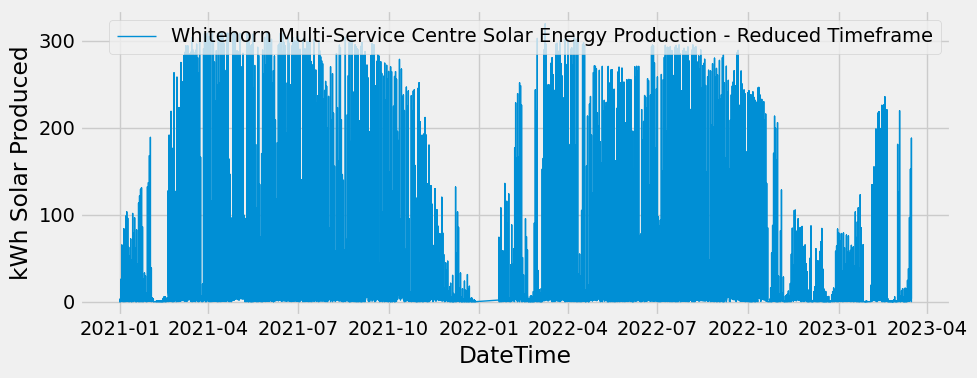

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 4))

plt.plot(df1.date, df1['kWh'], label=f'{plant} Solar Energy Production - Reduced Timeframe', linewidth=1)
plt.xlabel("DateTime")
plt.ylabel("kWh Solar Produced")

plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

#### Aggregate by date to eliminate noiseness of hourly data (nights do not have solar output)

In [11]:
df_agg = df1.groupby(['name','date']).agg({'kWh':'sum'}).reset_index()
df_agg.head()

,name,date,kWh
0,Whitehorn Multi-Service Centre,2021-01-01,7.017
1,Whitehorn Multi-Service Centre,2021-01-02,73.606
2,Whitehorn Multi-Service Centre,2021-01-03,293.457
3,Whitehorn Multi-Service Centre,2021-01-04,159.021
4,Whitehorn Multi-Service Centre,2021-01-05,375.844


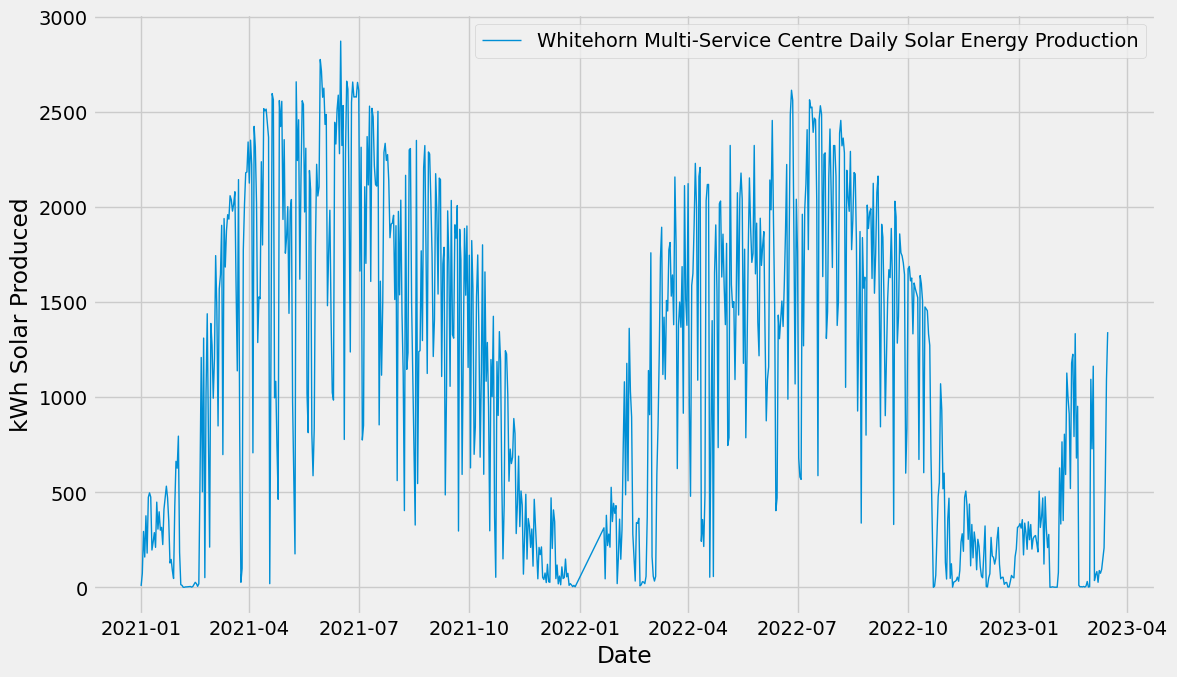

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))

plt.plot(df_agg.date, df_agg['kWh'], label=f'{plant} Daily Solar Energy Production', linewidth=1)
plt.xlabel("Date")
plt.ylabel("kWh Solar Produced")

plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

### Seasonality

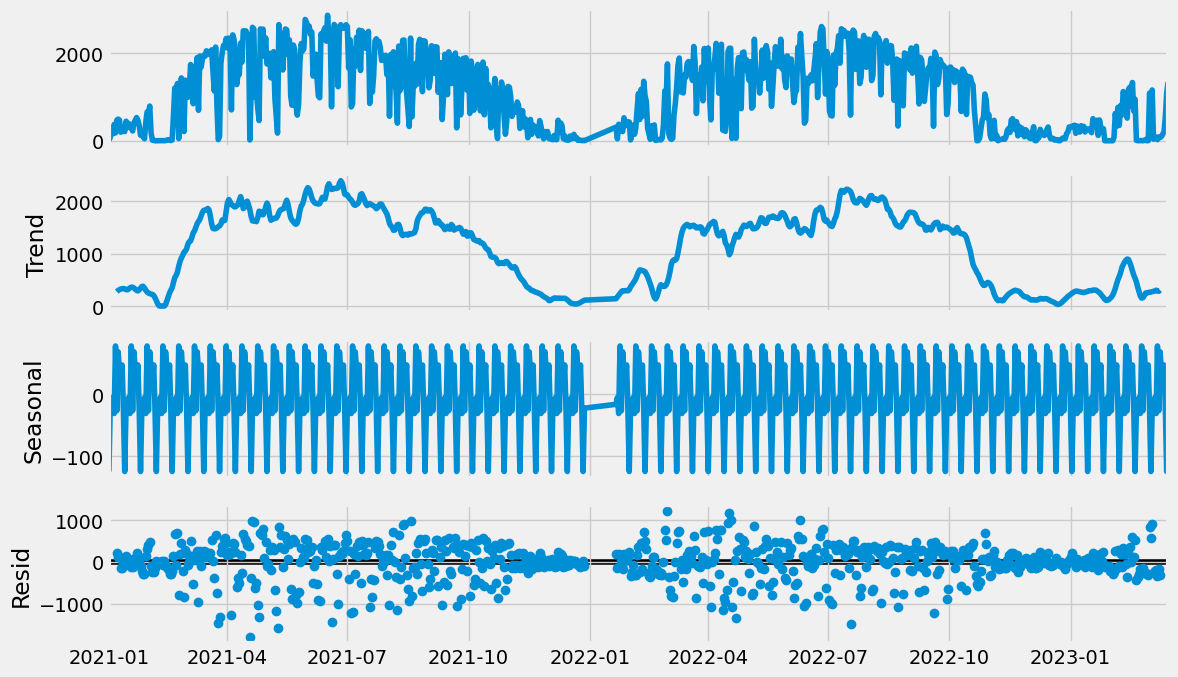

In [13]:
df_ts = df_agg[['date','kWh']].set_index('date')

# Decompose the time series (assuming monthly seasonality, period=12)
decomposition = seasonal_decompose(df_ts, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches((12, 7))
fig.tight_layout()
plt.show()

# Q-Learning Anomaly Detection Environment

In [14]:
class AnomalyDetectionEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.action_space = spaces.Discrete(2)  # 0: no anomaly, 1: anomaly
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.flagged_anomalies = []  # Store flagged anomalies

    def step(self, action):
        # Get the current data point and index
        current_value = self.data[self.current_step]
        current_index = self.current_step
        
        # If the agent flags it as an anomaly, store it
        if action == 1:  # 1 means anomaly
            self.flagged_anomalies.append((current_index, current_value))
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        
        # Return observation, reward, done, and info
        return np.array([current_value]), 0, done, {}

    def reset(self):
        self.current_step = 0
        self.flagged_anomalies = []  # Reset anomalies for a new episode
        return np.array([self.data[self.current_step]])

In [15]:
class QLearningAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.q_table = {}
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.9  # Discount factor
        self.epsilon = 0.85  # Exploration rate (1.0)
        self.epsilon_decay = 0.75 # 0.99
        self.epsilon_min = 0.05 # 0.1

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_size - 1)
        return np.argmax(self.q_table.get(tuple(state.flatten()), [0]*self.action_size))

    def update_q_value(self, state, action, reward, next_state):
        state_key = tuple(state.flatten())
        next_state_key = tuple(next_state.flatten())
        current_q = self.q_table.get(state_key, [0]*self.action_size)[action]
        max_future_q = max(self.q_table.get(next_state_key, [0]*self.action_size))
        
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        if state_key not in self.q_table:
            self.q_table[state_key] = [0] * self.action_size
        self.q_table[state_key][action] = new_q

In [16]:
# Training the agent
env = AnomalyDetectionEnv(df_agg['kWh'].values)
agent = QLearningAgent(env.action_space.n)
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        # Agent selects an action
        action = agent.get_action(state)
        # Environment responds to the action
        next_state, reward, done, _ = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

In [17]:
# Print flagged anomalies
# print("Flagged anomalies:", env.flagged_anomalies)

In [18]:
# Extract anomaly indexes
anomaly_indexes = {index for index, value in env.flagged_anomalies}

# Add a new column to the DataFrame
df_agg['qlearn_anomaly'] = df_agg.index.isin(anomaly_indexes).astype(int)

In [19]:
df_agg['qlearn_anomaly'].sum()

np.int64(20)

In [20]:
len(df_agg)

782

In [21]:
print(f"Q-Learning has detected anomalies in {100*df_agg['qlearn_anomaly'].sum()/len(df_agg):.2f}% of the observations")

Q-Learning has detected anomalies in 2.56% of the observations


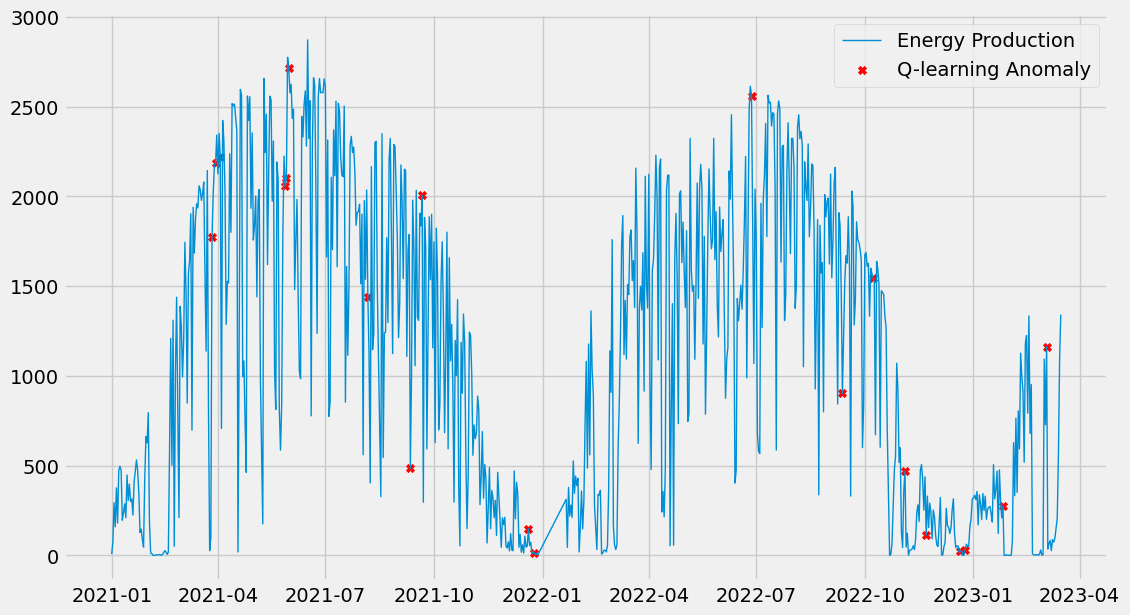

In [22]:
ql_anomaly_indices = np.where(df_agg.qlearn_anomaly==1)[0]
q_anomaly_x = df_agg['date'][ql_anomaly_indices]
q_anomaly_y = df_agg['kWh'][ql_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df_agg['date'], df_agg['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(q_anomaly_x, q_anomaly_y, color='red', marker='X', s=35, label='Q-learning Anomaly')
plt.legend()
plt.show()

In [23]:
# Evaluate the agent
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = agent.get_action(state)
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     state = next_state

# print(f'Total reward during evaluation: {total_reward}')

# Let's compare the Q-Learning anomalies with the results from an Isolation Forest

### Features for Model

In [24]:
df2 = df_agg.sort_values("date")

window = 7 # to capture the previous week

# Calculate rolling mean, minimum 1 period to avoid NaN
df2["rolling_mean"] = df2["kWh"].rolling(window=window, min_periods=1).mean()

# Calculate rolling standard deviation, minimum 1 period
df2["rolling_std"] = df2["kWh"].rolling(window=window, min_periods=1).std()

# Calculate rolling maximum, minimum 1 period
df2["rolling_max"] = df2["kWh"].rolling(window=window, min_periods=1).max()

# Calculate rolling minimum, minimum 1 period
df2["rolling_min"] = df2["kWh"].rolling(window=window, min_periods=1).min()

# Create lag features: value shifted by 1
df2["lag_1"] = df2["kWh"].shift(1)

# Create lag features: value shifted by 6
df2["lag_3"] = df2["kWh"].shift(6)

# Calculate the percentage change from the previous value
df2["pct_change"] = df2["kWh"].pct_change()

In [25]:
feature_cols = [
    "kWh",
    "rolling_mean",
    "rolling_std",
    "rolling_max",
    "rolling_min",
    "lag_1",
    "lag_3",
    "pct_change",
]

df2[feature_cols] = df2[feature_cols].replace([np.inf, -np.inf], np.nan)
df2[feature_cols] = df2[feature_cols].fillna(method="ffill").fillna(method="bfill")

In [26]:
# Initialize RobustScaler to scale features while being robust to outliers
scaler = RobustScaler()

# Fit the scaler on the feature matrix and transform the features accordingly
X = scaler.fit_transform(df2[feature_cols])

In [27]:
#TODO: update definition to return granular outlier status per observation to be used on validation set
def estimate_contamination(X, std_dev_threshold):
    """
    Estimate the contamination rate based on the proportion of outliers in each feature.
    
    Parameters:
    - X: numpy array of feature values
    
    Returns:
    - average_contamination: float representing the average contamination rate across features
    """
    outlier_proportions = []
    
    for feature_idx in range(X.shape[1]):
        # Extract all values for the current feature
        feature_values = X[:, feature_idx]
        
        # Calculate mean and standard deviation of the feature
        mean = np.mean(feature_values)
        std = np.std(feature_values)
        
        # Count the number of outliers beyond 3 standard deviations from the mean
        outliers = np.sum(np.abs(feature_values - mean) > std_dev_threshold * std)

        # Calculate the proportion of outliers in the current feature
        outlier_proportions.append(outliers / len(feature_values))
    
    # Return the average contamination rate across all features
    return np.mean(outlier_proportions), std_dev_threshold

In [28]:
def calc_outliers(df, feature, std_dev_threshold):

    X_feat = scaler.fit_transform(df[[feature]])
    df_feat = pd.DataFrame(X_feat, columns=[f'{feature}_scaled']).join(df[[feature, 'kWh']])
    
    df_feat['avg'] = df_feat[f'{feature}_scaled'].mean()
    df_feat['std'] = df_feat[f'{feature}_scaled'].std()
    df_feat[f'{feature}_outlier'] = np.where( abs(df_feat[f'{feature}_scaled'] - df_feat['avg']) > std_dev_threshold*df_feat['std'], 1, 0)
        
    return df_feat

In [29]:
# Estimate the contamination rate
contamination, std_dev_threshold = estimate_contamination(X=X, std_dev_threshold=1.75)

print(f"Based on a Std Dev Threshold of {std_dev_threshold}, the Estimated Contamination Rate is {100*contamination:.2f}% of the observations")

Based on a Std Dev Threshold of 1.75, the Estimated Contamination Rate is 2.59% of the observations


### Isolation Forest Model Training and Prediction
* Input a higher contamination rate to match the results of the Q Learning

In [30]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=12)

clf = IsolationForest(contamination=0.0217, random_state=12)

# Fit the Isolation Forest model on the training data
clf.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.0217
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,12
,verbose,0
,warm_start,False


In [31]:
X_val_rolling_mean = X_val[:, 1]
df_X_val_rolling_mean = pd.DataFrame(X_val_rolling_mean, columns=['rolling_mean']).join(df2[['kWh']])

df_outliers_X_val = calc_outliers(df=df_X_val_rolling_mean, feature='rolling_mean', std_dev_threshold=1.75)
val_true = df_outliers_X_val['rolling_mean_outlier'].to_numpy()

In [32]:
val_pred = clf.predict(X_val)
# convert from -1,1 to 0,1
val_pred = [0 if x == 1 else 1 for x in val_pred]

df_val_pred = pd.DataFrame(val_pred, columns=['isolation_forest_outlier'])
df_eval_outliers_comp = df_outliers_X_val.join(df_val_pred)

#### Comparison of Rolling Mean Std Dev Outliers and Isolation Forest Outliers found in the Evaluation Set
* Here, we are assuming the Rolling Mean model is Ground Truth!

In [33]:
df_eval_outliers_comp[(df_eval_outliers_comp.rolling_mean_outlier==1) | (df_eval_outliers_comp.isolation_forest_outlier==1)]

,rolling_mean_scaled,rolling_mean,kWh,avg,std,rolling_mean_outlier,isolation_forest_outlier
77,0.851269,0.870317,2015.277,-0.19258,0.559915,1,1
87,0.821703,0.841672,2179.380,-0.19258,0.559915,1,1
99,-1.030009,-0.952308,1517.073,-0.19258,0.559915,0,1
110,0.675409,0.699940,2562.476,-0.19258,0.559915,0,1
111,0.812313,0.832575,995.997,-0.19258,0.559915,1,1
118,-0.999364,-0.922618,1933.806,-0.19258,0.559915,0,1
138,0.011700,0.056923,1017.987,-0.19258,0.559915,0,1
155,0.805534,0.826007,1480.285,-0.19258,0.559915,1,1


In [34]:
f1 = f1_score(val_true, val_pred)
print(f"F1 Score when comparing 'Isolation Forest' Model to 'Rolling Mean Std Dev Threshold={std_dev_threshold}' Ground Truth Model: {f1:.4f}")

F1 Score when comparing 'Isolation Forest' Model to 'Rolling Mean Std Dev Threshold=1.75' Ground Truth Model: 0.6667


In [35]:
# Predict anomalies on the entire dataset using the trained Isolation Forest model
df2["isolation_forest_anomaly"] = clf.predict(X)

# Map the predictions to binary labels: 0 for normal instances, 1 for anomalies
df2["isolation_forest_anomaly"] = df2["isolation_forest_anomaly"].map({1: 0, -1: 1})  # Convert to 0 (normal) and 1 (anomaly)

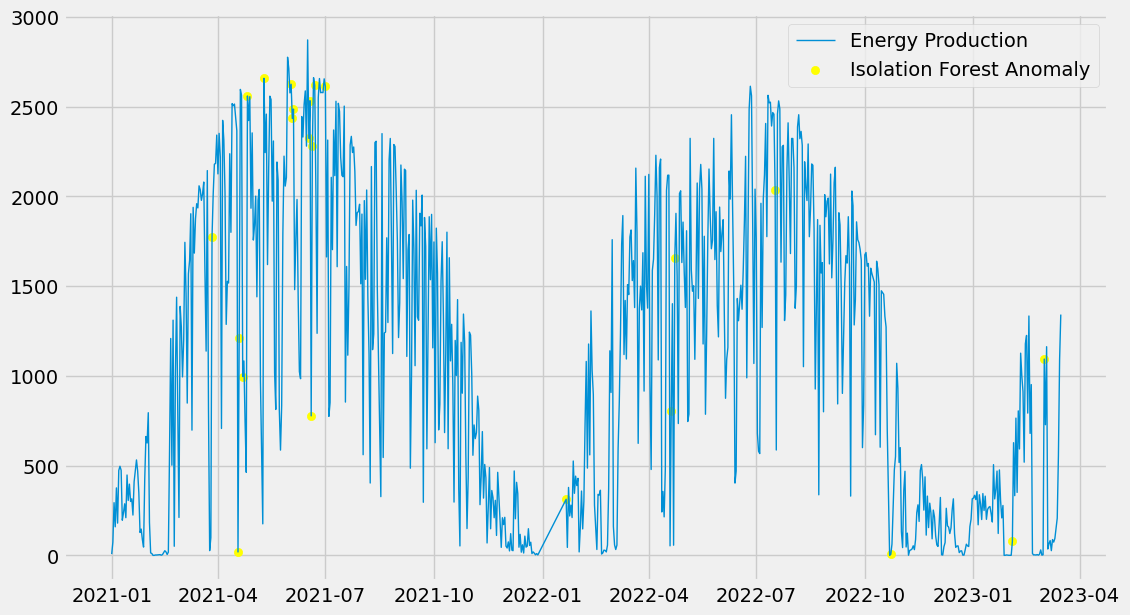

In [36]:
if_anomaly_indices = np.where(df2.isolation_forest_anomaly==1)[0]
if_anomaly_x = df2['date'][if_anomaly_indices]
if_anomaly_y = df2['kWh'][if_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df2['date'], df2['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(if_anomaly_x, if_anomaly_y, color='yellow', marker='o', s=35, label='Isolation Forest Anomaly')
plt.legend()
plt.show()

### Calculate Rolling Mean model for entire observation set

In [37]:
df_complete_ground_truth = calc_outliers(df=df2, feature='rolling_mean', std_dev_threshold=1.75)
df3 = df2.join(df_complete_ground_truth[['rolling_mean_outlier']])

# Compare All Three Models

In [38]:
ql_anomaly_indices = np.where(df3.qlearn_anomaly==1)[0]
if_anomaly_indices = np.where(df3.isolation_forest_anomaly==1)[0]
rm_anomaly_indices = np.where(df3.rolling_mean_outlier==1)[0]

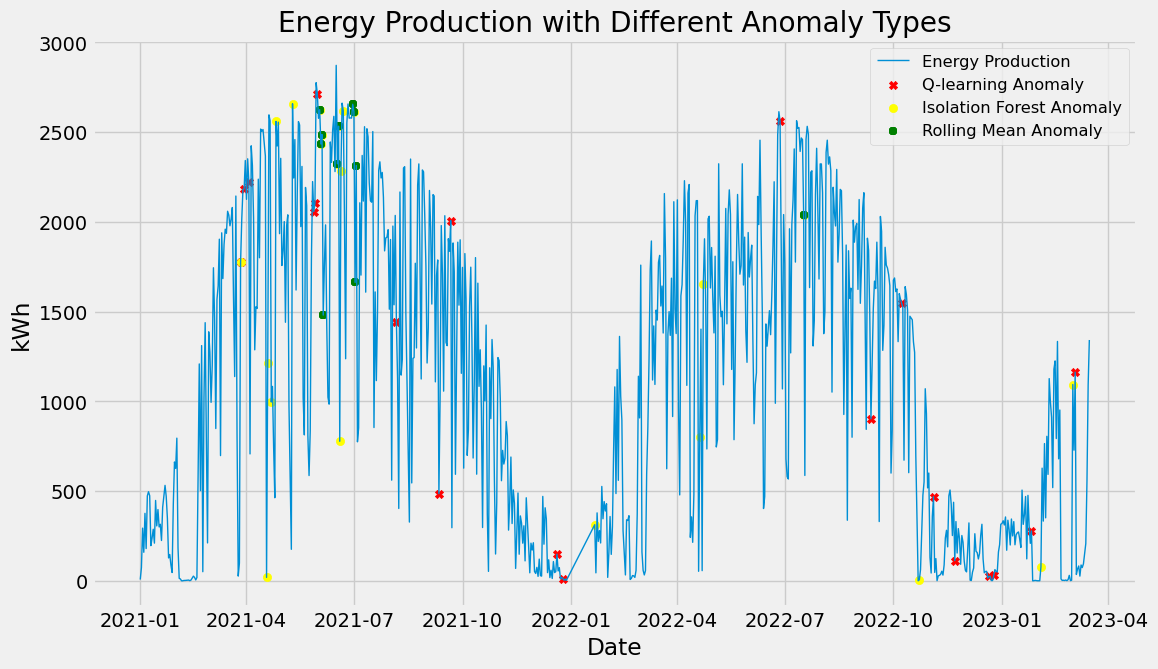

In [39]:
q_anomaly_x = df3['date'][ql_anomaly_indices]
q_anomaly_y = df3['kWh'][ql_anomaly_indices]
if_anomaly_x = df3['date'][if_anomaly_indices]
if_anomaly_y = df3['kWh'][if_anomaly_indices]
rm_anomaly_x = df3['date'][rm_anomaly_indices]
rm_anomaly_y = df3['kWh'][rm_anomaly_indices]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 7))
# Plot the line chart
plt.plot(df3['date'], df3['kWh'], label='Energy Production', linewidth=1)

# Mark anomalies with a different marker
plt.scatter(q_anomaly_x, q_anomaly_y, color='red', marker='X', s=35, label='Q-learning Anomaly')
plt.scatter(if_anomaly_x, if_anomaly_y, color='yellow', marker='o', s=35, label='Isolation Forest Anomaly')
plt.scatter(rm_anomaly_x, rm_anomaly_y, color='green', marker='+', s=35, label='Rolling Mean Anomaly')

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Energy Production with Different Anomaly Types')
plt.legend(fontsize='small')
plt.grid(True)
plt.show()

### Let's Zoom in a bit see compare models better

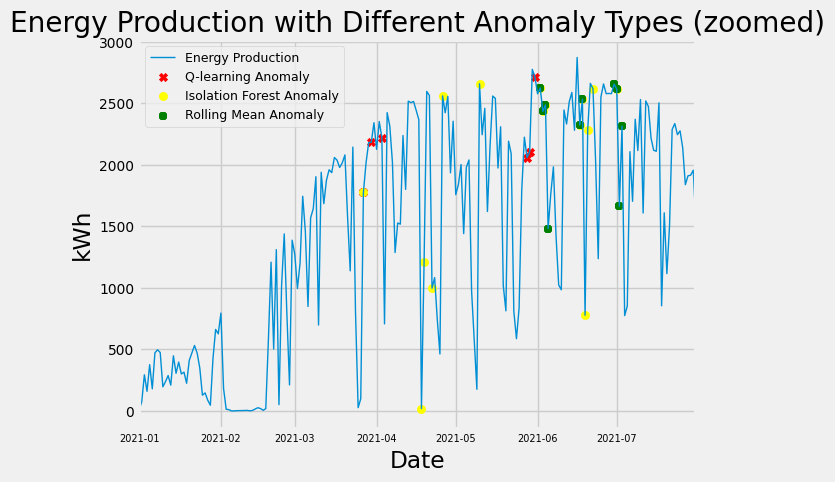

In [40]:
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 7, 31)

fig, ax = plt.subplots()
ax.plot(df3['date'], df3['kWh'], label='Energy Production', linewidth=1)
ax.set_xlim(start_date, end_date)
plt.xticks(fontsize=7)
plt.yticks(fontsize=10)
plt.xlabel('Date')
plt.ylabel('kWh')
plt.title('Energy Production with Different Anomaly Types (zoomed)')
# Mark anomalies with a different marker
ax.scatter(q_anomaly_x, q_anomaly_y, color='red', marker='X', s=35, label='Q-learning Anomaly')
ax.scatter(if_anomaly_x, if_anomaly_y, color='yellow', marker='o', s=35, label='Isolation Forest Anomaly')
ax.scatter(rm_anomaly_x, rm_anomaly_y, color='green', marker='+', s=35, label='Rolling Mean Anomaly')
plt.legend(fontsize=9)
plt.show()

In [41]:
df_summary = df3.groupby(['name','qlearn_anomaly','isolation_forest_anomaly','rolling_mean_outlier']).agg({'date':'count'}).rename(columns={'date':'count_obs'}).reset_index()
df_summary
df_tot = df_summary.groupby(['name']).agg({'count_obs':'sum'}).rename(columns={'count_obs':'tot_obs'}).reset_index()
df_summary2 = df_summary.merge(df_tot, how='left', on='name')
df_summary2['pct_tot'] = df_summary2.count_obs/df_summary2.tot_obs
df_summary2.drop(columns=['tot_obs'], inplace=True)
df_summary2

,name,qlearn_anomaly,isolation_forest_anomaly,rolling_mean_outlier,count_obs,pct_tot
0,Whitehorn Multi-Service Centre,0,0,0,737,0.942455
1,Whitehorn Multi-Service Centre,0,0,1,4,0.005115
2,Whitehorn Multi-Service Centre,0,1,0,14,0.017903
3,Whitehorn Multi-Service Centre,0,1,1,7,0.008951
4,Whitehorn Multi-Service Centre,1,0,0,19,0.024297
5,Whitehorn Multi-Service Centre,1,1,0,1,0.001279


### Bonus: Prophet Time Series Modeling
* Leverage full time-series dataset

In [42]:
df0.dtypes

name                        object
id                           int64
address                     object
date                datetime64[ns]
kWh                        float64
public_url                  object
installationDate            object
uid                         object
datetime            datetime64[ns]
dtype: object

In [43]:
df0.head()

,name,id,address,date,kWh,public_url,installationDate,uid,datetime
230707,Whitehorn Multi-Service Centre,319086,3705 35 ST NE,2017-02-13,0.564,https://monitoring.solaredge.com/solaredge-web...,2016/12/13,3190862017-02-13 09:45:00,2017-02-13 09:45:00
230708,Whitehorn Multi-Service Centre,319086,3705 35 ST NE,2017-02-13,17.131,https://monitoring.solaredge.com/solaredge-web...,2016/12/13,3190862017-02-13 10:45:00,2017-02-13 10:45:00
230709,Whitehorn Multi-Service Centre,319086,3705 35 ST NE,2017-02-13,48.468,https://monitoring.solaredge.com/solaredge-web...,2016/12/13,3190862017-02-13 11:45:00,2017-02-13 11:45:00
230710,Whitehorn Multi-Service Centre,319086,3705 35 ST NE,2017-02-13,76.175,https://monitoring.solaredge.com/solaredge-web...,2016/12/13,3190862017-02-13 12:45:00,2017-02-13 12:45:00
230711,Whitehorn Multi-Service Centre,319086,3705 35 ST NE,2017-02-13,79.399,https://monitoring.solaredge.com/solaredge-web...,2016/12/13,3190862017-02-13 13:45:00,2017-02-13 13:45:00


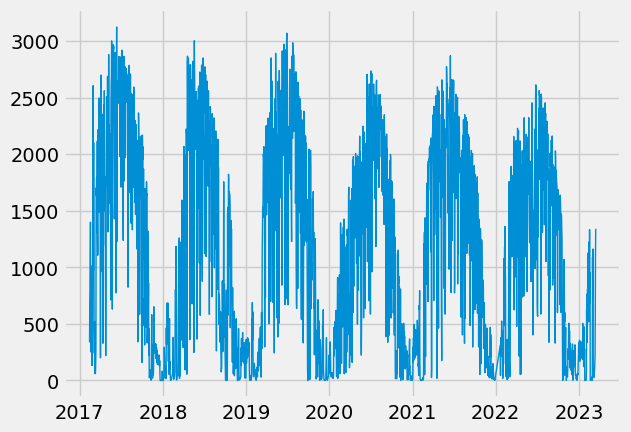

In [44]:
df_agg0 = df0.groupby(['name','date']).agg({'kWh':'sum'}).reset_index()

df_t = df_agg0[['date', 'kWh']].reset_index(drop=True).rename(columns={'date':'ds','kWh':'y'})
plt.plot(df_t['ds'], df_t['y'], label='Energy Production', linewidth=1)
plt.show()

In [45]:
df_data_train = df_t[df_t["ds"] < "2021-01"]
df_data_test = df_t[df_t["ds"] >= "2021-01"]

In [46]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_data_train)  # Fit model with given params
    df_cv = cross_validation(m, period='180 days', horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

Optimization terminated abnormally. Falling back to Newton.
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] start processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:52 - cmdstanpy - INFO - Chain [1] done processing
13:45:

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   883.429068
1                     0.001                     0.10   640.263942
2                     0.001                     1.00   634.628966
3                     0.001                    10.00   633.625525
4                     0.010                     0.01   719.301587
5                     0.010                     0.10   597.251292
6                     0.010                     1.00   600.734305
7                     0.010                    10.00   604.555837
8                     0.100                     0.01  1522.014719
9                     0.100                     0.10   627.792554
10                    0.100                     1.00   632.520692
11                    0.100                    10.00   630.413315
12                    0.500                     0.01  2320.601537
13                    0.500                     0.10   692.059379
14        

13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] start processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing
13:46:13 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


### Fit model on training data

In [48]:
model1 = Prophet(**best_params
                )

model1.fit(df_data_train)

In [49]:
future = model1.make_future_dataframe(periods=805, freq='d')
forecast = model1.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-02-13,507.647570,-204.537063,1229.118438
1,2017-02-14,493.870038,-294.593140,1126.664461
2,2017-02-15,527.711895,-213.046813,1271.868317
3,2017-02-16,508.979543,-190.158634,1162.016442
4,2017-02-17,480.363291,-226.130571,1184.690667
...,...,...,...,...
2204,2023-03-12,574.774981,-126.294168,1267.505438
2205,2023-03-13,639.749473,-60.341316,1300.122433
2206,2023-03-14,648.878315,-31.552627,1317.662005
2207,2023-03-15,705.905214,19.213162,1390.930202


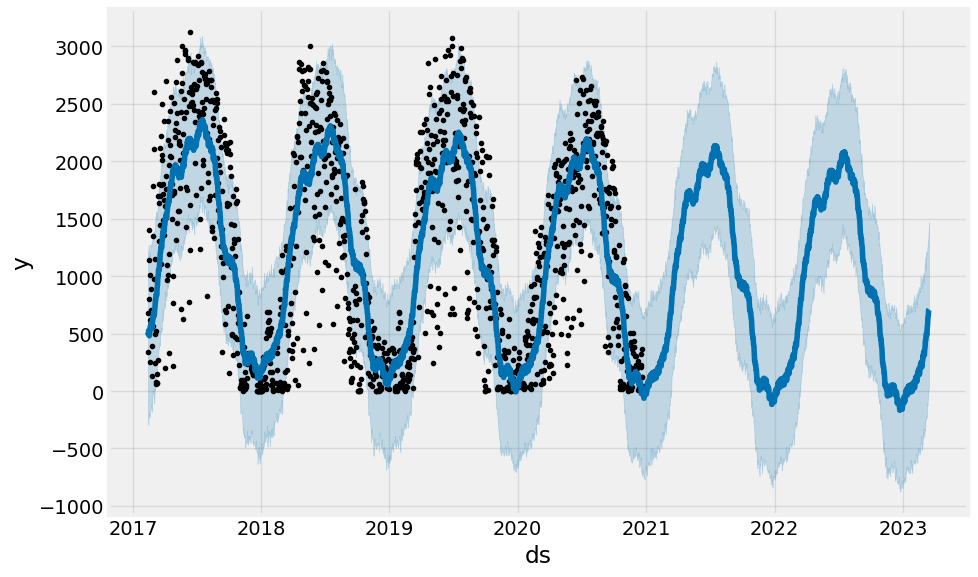

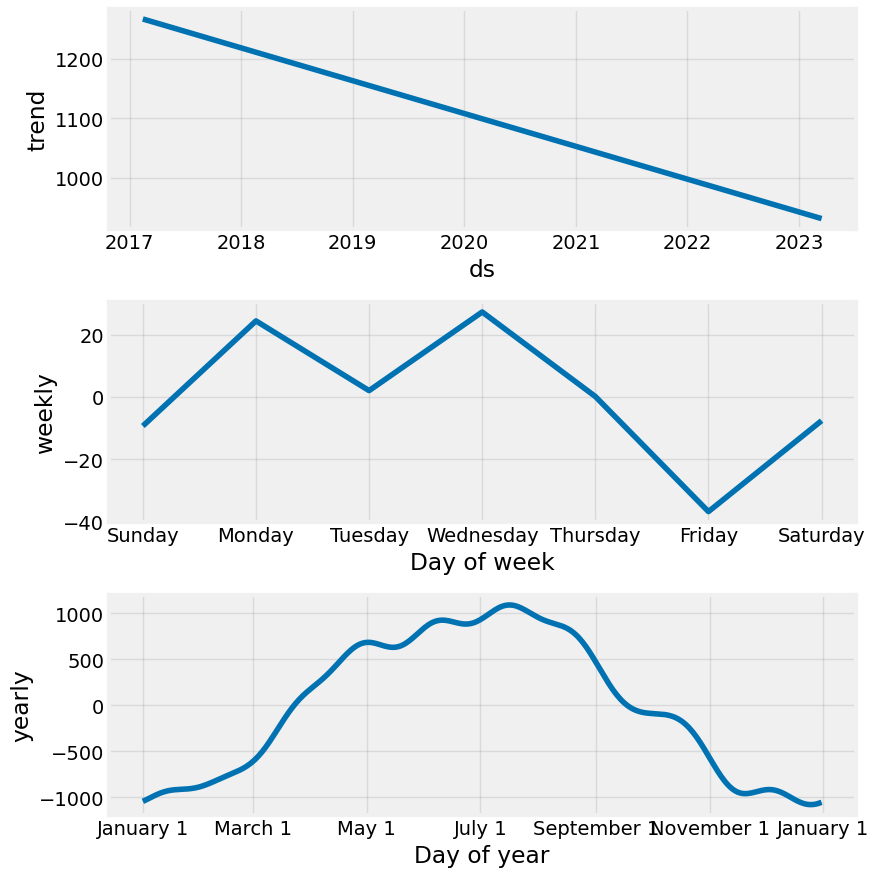

In [50]:
# Plot the forecast
fig = model1.plot(forecast)

# Plot components (seasonality and trends)
fig_components = model1.plot_components(forecast)

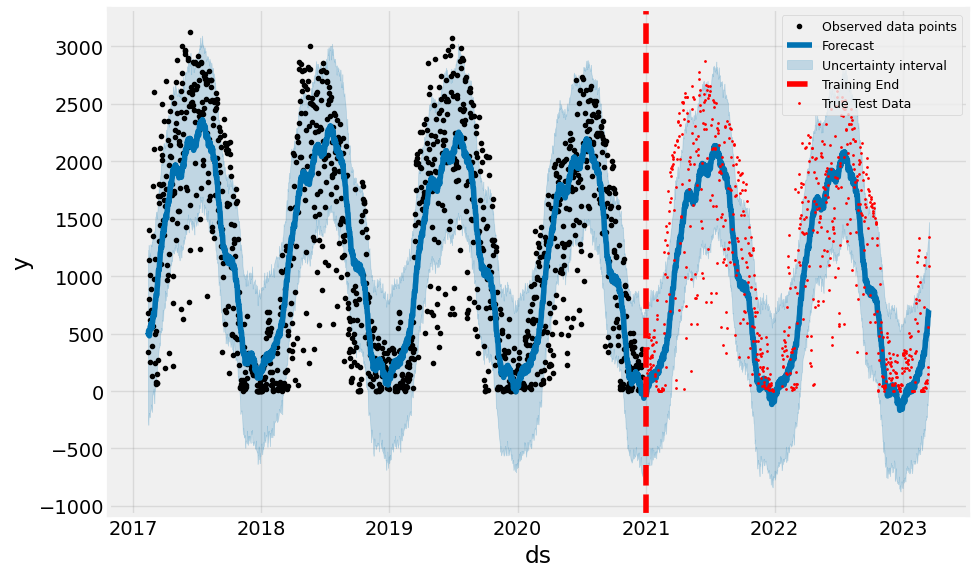

In [51]:
# plot the time series 
forecast_plot = model1.plot(forecast)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast['ds'].iloc[-805]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
# df_data_test['Month'] = pd.to_datetime(df_data_test['Month'])
plt.plot(df_data_test['ds'], df_data_test['y'],'ro', markersize=1, label='True Test Data')

plt.legend(fontsize=9)
plt.show()

In [52]:
df_data_test_idx = df_data_test.set_index('ds')

df_data_test_idx

,y
ds,
2021-01-01,7.017
2021-01-02,73.606
2021-01-03,293.457
2021-01-04,159.021
2021-01-05,375.844
...,...
2023-03-12,150.158
2023-03-13,207.440
2023-03-14,555.664


### Reindex test data to create rows for missing dates

In [53]:
full_date_range = pd.date_range(start=df_data_test_idx.index.min(), end=df_data_test_idx.index.max(), freq='D')
df_test_reindexed = df_data_test_idx.reindex(full_date_range)


imputer = SimpleImputer(strategy='mean')
df_test_reindexed2 = pd.DataFrame(imputer.fit_transform(df_test_reindexed), columns=df_test_reindexed.columns)

In [54]:
forecast_eval = forecast[forecast.ds>='2021-01-01'].reset_index(drop=True)

In [55]:
# Calculate metrics
mae = mean_absolute_error(df_test_reindexed2['y'], forecast_eval['yhat'])
rmse = np.sqrt(mean_squared_error(df_test_reindexed2['y'], forecast_eval['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 474.95
RMSE: 593.59
